In [1]:
import scipy.io as scio
import numpy as np    
import matplotlib.pyplot as plt
import sys
import os
import math
import pprint
import cv2
from scipy.misc import imsave
from helper import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Setting the directories
import os
cwd = os.getcwd()
main_direct = '/datasets/OCTData/Atrium/'
directory = cwd + main_direct # main directory
# Extensions
raw_ext = '.tif'
label_ext = '.JPG'

files = {}
for number, filename in enumerate(sorted(os.listdir(directory)), start=1):
    files[number] = filename
#     print(files[number])

sub_directory = directory+files[2]+'/'
print(sub_directory)

image = plt.imread(sub_directory+'con_'+files[2]+raw_ext)
# show_main_image(image)
label_image = plt.imread(sub_directory+'label_'+files[2]+label_ext)
# show_main_image(label_image)


# Testing images saved correctly
# test_raw = "/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H1_N01848_LA_1_272/Resized_train/con_H1_N01848_LA_1_272_1.tif"
# test_label = "/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H1_N01848_LA_1_272/Resized_train/label_H1_N01848_LA_1_272_1.JPG"
# test_colour = "/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H1_N01848_LA_1_272/Resized_train/label_H1_N01848_LA_1_272_colour_1.JPG"
# test_weight = np.load('/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H1_N01848_LA_1_272/Resized_train/label_H1_N01848_LA_1_272_weight_1.npy')

# image_raw = plt.imread(test_raw)
# image_label = plt.imread(test_label)
# image_colour = plt.imread(test_colour)
# print(image_raw.shape)
# print(image_label.shape)
# print(image_colour.shape)

# show_main_image(image_raw)
# show_main_image(image_label)
# show_main_image(image_colour)
# show_main_image(test_weight)

/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H1_N01848_LA_1_388/


#### Rename Labelled Images

In [3]:
# Rename files in folder
rename = False

if rename:
    for number, filename in sorted(files.items()):
        sub_directory = directory+files[number]+'/'
        for f in os.listdir(sub_directory):
            ext = f[-4:]
            if ext == label_ext:
                print(sub_directory)
                old_filename = sub_directory+f
                new_filename = sub_directory+'label_'+filename+label_ext
                print("Old Filename: {}, New Filename: {}".format(old_filename, new_filename))
                os.rename(old_filename, new_filename)

#### Create New Directory

Only have 19 atriums - need to create more segments of data

In [4]:
make_new_directory = False
if make_new_directory:
    for number, filename in sorted(files.items()):
        sub_directory = directory+files[number]+'/'
        for f in os.listdir(sub_directory):
            ext = f[-4:]
            # If the file isn't an ipynb notebook file and it's the .tif file
            if ext == raw_ext:
                path = sub_directory+'Resized_train'
                os.mkdir(path)

####  Helper functions to find colours in image

In [5]:
def to_rgb(color):
    r,g,b = color
    return (int(r),int(g),int(b))

# Source: https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in wb.css3_hex_to_names.items():
        r_c, g_c, b_c = wb.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = wb.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

# Source Source: https://stackoverflow.com/questions/45043617/count-the-number-of-objects-of-different-colors-in-an-image-in-python
def find_colors(file_name):
    from skimage import io, morphology, measure
    from sklearn.cluster import KMeans

    img = io.imread(file_name)

    rows, cols, bands = img.shape
    X = img.reshape(rows*cols, bands)


    kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
    labels = kmeans.labels_.reshape(rows, cols)

    for i in np.unique(labels):
        blobs = np.int_(morphology.binary_opening(labels == i))
        color = np.around(kmeans.cluster_centers_[i])
        actual_name, closest_name = get_colour_name(to_rgb(color))
        count = len(np.unique(measure.label(blobs))) - 1
        
        print('Color: {}, RGB: {}  >>  Objects: {}'.format(closest_name,color, count))
        
def pixel_colors(file_name):
    '''
    Creating a dictionary of colours to see what colors are in images.
    '''
    from skimage import io
    if type(file_name) == str:
        img = io.imread(file_name)
    else:
        img = file_name
    
    new_img = np.copy(img)
    rows, cols, bands = new_img.shape
    
    dict_of_colours = {}
    for row in range(150,350):
        if row % 25 == 0:
            print(row)
        for col in range(0,50):
            pixel_color = new_img[row][col]
            actual, close = get_colour_name(pixel_color)
            if actual != None:
                if actual in dict_of_colours:
                    dict_of_colours[actual] += 1
                else:
                    dict_of_colours[actual] = 1
                list_of_colors.add(actual)
            else:
                if close in dict_of_colours:
                    dict_of_colours[close] += 1
                else:
                    dict_of_colours[close] = 1

    return dict_of_colours

#### Finding Colours/id of a class
https://www.w3schools.com/colors/colors_picker.asp

In [6]:
import webcolors as wb
import numpy as np
from skimage import io
from skimage.color import rgb2lab, deltaE_cie76
from PIL import Image

# Source: https://stackoverflow.com/questions/44428315/similar-color-detection-in-python

# Blurring image 
def blur_image(img, b):
    if b == "average":
        kernel = np.ones((3,6),np.float32)/25
        blurred = cv2.filter2D(img,-1,kernel)
    elif b == "gaussian":
    # Gaussian Blur
        blur=cv2.GaussianBlur(img,(13,13),0)
        blurred=cv2.cvtColor(blur,cv2.COLOR_BGR2HSV)
    elif b == "bilateral":
    # Bilaterial Filter
        blur=cv2.bilateralFilter(img,4,25,25)
        blurred=cv2.cvtColor(blur,cv2.COLOR_BGR2HSV)
    return blurred

def turn_array(rgb):
    '''
    turn rgb into np.array
    '''
    return np.uint8(np.asarray([[rgb]]))

def turn_rgb_2_lab(color, lab):
    '''
    Convert RGB to CIE 1976 L*a*b*
    '''
    return deltaE_cie76(rgb2lab(color),lab)

def rgb_to_id(rgb, threshold, color, ids, lab):
    '''
    Convert rgb to id
    '''
#     print(get_colour_name(color), color, ids)
    color_3d = turn_array(color)
    dE_color = turn_rgb_2_lab(color_3d, lab)
    rgb[dE_color < threshold] = ids

    return rgb

def ref_colour(rgb):
    '''
    Finding colours within a range of the colour input
    input = pixel
    '''
#     rgb = io.imread('https://i.stack.imgur.com/npnrv.png') # to show where the images overlap
    new_rgb = np.copy(rgb)
    
    lab = rgb2lab(new_rgb)
    
    threshold = 15  
    
    # Lime and limegreen is same as Green 
    green = [0,128,0]
    lime = [0,255,0]
    limegreen = [50, 205, 50]
    
    rgb_to_id(new_rgb, threshold, green, 0, lab)
    rgb_to_id(new_rgb, threshold, lime, 0, lab)
    rgb_to_id(new_rgb, threshold, limegreen, 0, lab)
    
    # Orange is same as dark orange
    orange = [255, 165, 0]
    darkorange = [255, 140, 0]
    chocolate = [180,101,24]
    
    rgb_to_id(new_rgb, threshold, orange, 1, lab)
    rgb_to_id(new_rgb, threshold, darkorange, 1, lab)
    rgb_to_id(new_rgb, threshold, chocolate, 1, lab)
    
    # Dark Violet = Purple = Medium Purple = Darkorchid
    purple = [128,0,128]
    darkviolet = [177,10,255]
    mediumpurple = [147, 112, 219]
    darkorchid = [153, 50, 204]
    
    rgb_to_id(new_rgb, threshold, purple, 2, lab)
    rgb_to_id(new_rgb, threshold, darkviolet, 2, lab)
    rgb_to_id(new_rgb, threshold, mediumpurple, 2, lab)
    rgb_to_id(new_rgb, threshold, darkorchid, 2, lab)
    
    # Magenta/Fuschia
    magenta = [255,0,255]
    darkmagenta = [139, 0, 139]
    
    magenta_threshold = 20
    
    rgb_to_id(new_rgb, magenta_threshold, magenta, 3, lab)
    rgb_to_id(new_rgb, magenta_threshold, darkmagenta, 3, lab)
    
    # Blue
    blue = [0, 0, 255]
    darkslateblue = [72, 61, 139]
    midnightblue = [25, 25, 112]
    mediumblue = [0, 0, 205]
    
    rgb_to_id(new_rgb, threshold, blue, 4, lab)
    rgb_to_id(new_rgb, threshold, darkslateblue, 4, lab)
    rgb_to_id(new_rgb, threshold, midnightblue, 4, lab)
    rgb_to_id(new_rgb, threshold, mediumblue, 4, lab)
    
    # Yellow = Gold
    yellow = [255,255,0]
    gold = [255, 215, 0]
    goldenrod = [218, 165, 32]
    goldenrod2 = [183,178,36]
    darkgoldenrod = [184, 134, 11]
    
    rgb_to_id(new_rgb, threshold, yellow, 5, lab)
    rgb_to_id(new_rgb, threshold, gold, 5, lab)
    rgb_to_id(new_rgb, threshold, goldenrod, 5, lab)
    rgb_to_id(new_rgb, threshold, goldenrod2, 5, lab)
    rgb_to_id(new_rgb, threshold, darkgoldenrod, 5, lab)
    
    # Red = OrangeRed
    red = [255,0,0]
    orangered = [255, 69, 0]
    firebrick = [181,17,17]
    
    rgb_to_id(new_rgb, threshold, red, 6, lab)
    rgb_to_id(new_rgb, threshold, orangered, 6, lab)
    rgb_to_id(new_rgb, threshold, firebrick, 6, lab)
    
    # Black = Grey 
    black = [0, 0, 0]
    dimgrey = [105, 105, 105]
    darkslategrey = [47, 79, 79]
    lightgrey = [211, 211, 211]
    gainsboro = [220, 220, 220]
    grey = [128, 128, 128]
    lightslategrey = [119, 136, 153]
    darkgrey = [169, 169, 169]
    
    # NOTE: USED TO BE -1 BUT CHANGED AS VALUE NEEDED FOR CROSS ENTROPY - CAN'T HAVE 0
    rgb_to_id(new_rgb, threshold, black, 7, lab)
    rgb_to_id(new_rgb, threshold, dimgrey, 7, lab)
    rgb_to_id(new_rgb, threshold, darkslategrey, 7, lab)
    rgb_to_id(new_rgb, threshold, lightgrey, 7, lab)
    rgb_to_id(new_rgb, threshold, gainsboro, 7, lab)
    rgb_to_id(new_rgb, threshold, grey, 7, lab)
    rgb_to_id(new_rgb, threshold, lightslategrey, 7, lab)
    rgb_to_id(new_rgb, threshold, darkgrey, 7, lab)

    new_grey = cv2.cvtColor( new_rgb, cv2.COLOR_RGB2GRAY ) # convert image to grayscale
    
    return new_grey

def convert_to_id_image(image):
    '''
    convert rgb images to id
    '''
    returned_grey_image = ref_colour(image)
    rows, cols = returned_grey_image.shape
    g_y = np.copy(returned_grey_image)
    for x in range(0, rows):
        for j in range(0,cols):
#             if returned_grey_image[x][j] > 7: # Setting values in the array to void if they're not in labels
#                 returned_grey_image[x][j] = -1 # this created issue with cross_entropy
            if returned_grey_image[x][j] > 6: # Setting values in the array to void if they're not in labels
                g_y[x][j] = 7
    print(np.unique(g_y))
    return g_y

def convert_to_rgb_image(id_image):
    '''
    Convert id back to rgb 
    '''
    rows, cols = id_image.shape

    lime = [0,255,0] # id = 0
    darkorange = [255, 140, 0] # id = 1
    darkviolet = [177,10,255] # id = 2
    magenta = [255,0,255] # id = 3
    blue = [0, 0, 255] # id = 4
    yellow = [255, 255, 0] # id = 5
    red = [255,0,0] # id = 6
    black = [0, 0, 0]# id = 7
    
    colors = [ lime, darkorange, darkviolet, magenta, blue, yellow, red, black]
    new_image = np.zeros((rows,cols,3))
    for x in range(0, rows):
        for j in range(0,cols):
            pixel_value = int(id_image[x][j])
            if pixel_value > 6: # Setting values in the array to black if they're not in labels
                new_image[x][j] = black
            else:
                new_image[x][j] = colors[pixel_value] # setting id to colours - values between 0-6
    return new_image.astype(np.uint8)

Blurred images produce worse results as can be seen in the function below.

In [7]:
def produce_images(file_name):
    '''
    Display images from rgb to id back to rgb
    
    Returns id_image
    '''
    if type(file_name) == str:
        image = plt.imread(file_name)
    else:
        image = file_name
#     show_main_image(image)
    id_image = convert_to_id_image(image)
#     show_main_image(id_image)
    rgb_image = convert_to_rgb_image(id_image)
#     show_main_image(rgb_image)
    return id_image

In [8]:
# blurred_image = blur_image(label_image)
# pprint.pprint(pixel_colors(blurred_image))
# atrium_folder = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/png_labels_atrium'
# test_image = atrium_folder + '/label_H1_N01848_LA_1_272_labels.png'
# test_image = plt.imread(test_image)
# show_main_image(test_image)
# rgb_image = convert_to_rgb_image(test_image)
# show_main_image(rgb_image)

In [9]:
# Extensions
raw_ext = '.tif'
label_ext = '.JPG'

files = {}
for number, filename in enumerate(sorted(os.listdir(directory)), start=1):
    files[number] = filename
print(filename)
for i in range(2,3):
    type_of_heart = files[i][10:]
    print(type_of_heart)
    if type_of_heart[1:2] == 'A':
        sub_directory = directory+files[i]+'/'
        file_name = sub_directory+'label_'+files[i]+label_ext
        print(file_name)
        id_image = produce_images(file_name)

H8_N03585_RA_1_345
LA_1_388
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H1_N01848_LA_1_388/label_H1_N01848_LA_1_388.JPG
[1 2 3 5 7]


In [10]:
# show_main_image(id_image)
# print(id_image.shape)

In [11]:
# Applying Weighting algorithm to an image
def weighting_algo(id_image):
    '''
    Creating weighting of an image
    '''
    image = id_image
    x,y = image.shape
    weighted_image = np.zeros((x,y))
    for j in range(x):
        for k in range(y):
            # Setting weights for the image
            if(image[j][k]==0):
                w2 = 5
            elif(image[j][k] == 1):
                w2 = 5
            elif(image[j][k]== 2):
                w2 = 5 
            elif(image[j][k] == 3):
                w2 = 5 
            elif(image[j][k]== 4):
                w2 = 5 
            elif(image[j][k]== 5):
                w2 = 5 
            elif(image[j][k]== 6):
                w2 = 5 
            else:
                w2 = 0
            if(j!=0 and j!=x-1):
                next_pix = image[j+1][k]
                prev_pix = image[j-1][k]
                # Taking the derivative of the pixels
                if((next_pix-prev_pix)>0 and w2!=0):
                    w1 = 10  
                else:
                    w1 = 0
            else:
                w1 = 0
            w = 1 + w1 + w2
            weighted_image[j][k] = w
    return weighted_image

In [12]:
# weighted_image = weighting_algo(id_image)
# show_main_image(weighted_image)

In [13]:
# sub_directory = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H1_N01848_LA_1_272/'
# word = 'label_H1_N01848_LA_1_272.JPG'
# ext = '.JPG'
# i = 0
# save_np_array(weighted_image, sub_directory, word, ext, i)

#### Make Segments

In [14]:
# Save segmented images and weighted images.
def save_all(segmented_image, sub_directory, word, ext, i):
    
    # saving colour segmented image
    save_image(segmented_image, sub_directory, word, ext, i, True)
                        
    # converting colour segmented image into image id   
    id_image = produce_images(segmented_image) 

    # convert image_id into weighted image 
    weighted_image = weighting_algo(id_image)
    
    # making sure shap of np array is correct
    h,w = id_image.shape
    if h != 512 or w != 64:
        amount = 512 - h
        weight_full = np.full((amount, 64), 1)
        id_full = np.full((amount, 64), 255)
        new_weighted_image = np.concatenate((weighted_image, weight_full))
        new_id_image = np.concatenate((id_image, id_full))
        print(new_id_image.shape)
        save_np_array(new_id_image, sub_directory, word, ext, i, True)
        save_np_array(new_weighted_image, sub_directory, word, ext, i)
    else:
        # saving as np array 
        save_np_array(id_image, sub_directory, word, ext, i, True)
        save_np_array(weighted_image, sub_directory, word, ext, i)
    
#     show_main_image(weighted_image)
    
    print('saved_array',i+1)
    
    oct_image = rgb_to_grey(segmented_image) # convert image to greyscale
    save_image(oct_image, sub_directory, word, ext, i, False) # only save_image because don't need the weighted array

# Deleting wrongly named files
for number, filename in sorted(files.items()):
    if files[number][-2:] != 'h5':
        sub_directory = directory+files[number]+'/Resized_train/'
        for f in os.listdir(sub_directory):
            ext = f[-4:]
            if ext == '.npy' and f[-5:-4] == 't':
                silentremove(sub_directory+f)

/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H1_N01848_LA_1_272/
Resized_train
con_H1_N01848_LA_1_272.tif
label_H1_N01848_LA_1_272.JPG
[1 2 3 5 7]


/home/sim/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in ubyte_scalars


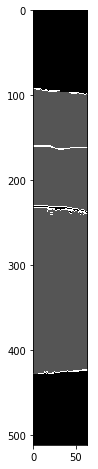

saved_array 1
[1 2 3 5 7]


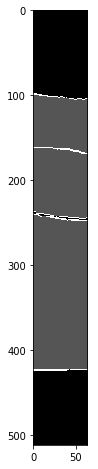

saved_array 2
[1 2 3 5 7]


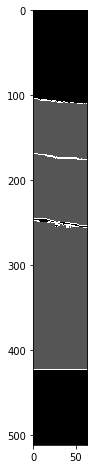

saved_array 3
[1 2 3 5 7]


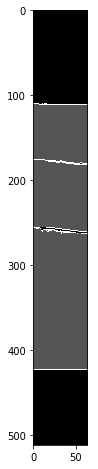

saved_array 4
[1 2 3 5 7]


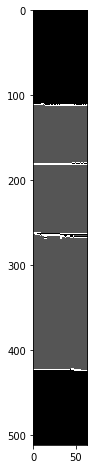

saved_array 5
[1 2 3 5 7]


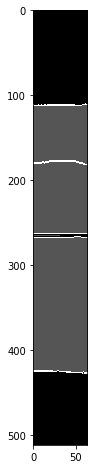

saved_array 6
[1 2 3 4 5 7]


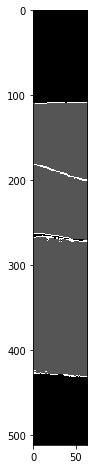

saved_array 7
[1 2 3 5 7]


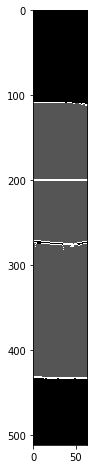

saved_array 8
[1 2 3 5 6 7]


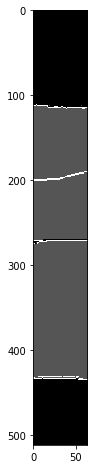

saved_array 9
.ipynb_checkpoints
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H1_N01848_LA_1_388/
Resized_train
con_H1_N01848_LA_1_388.tif
label_H1_N01848_LA_1_388.JPG
[1 2 3 5 7]


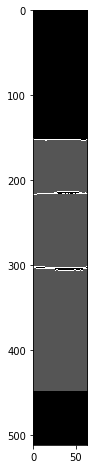

saved_array 1
[1 3 5 7]


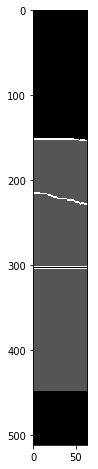

saved_array 2
[1 3 5 7]


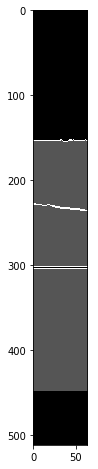

saved_array 3
[1 2 3 5 7]


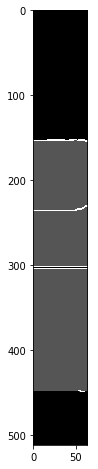

saved_array 4
[1 2 3 5 7]


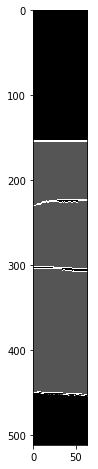

saved_array 5
[1 2 3 5 7]


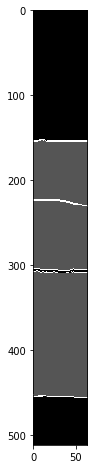

saved_array 6
[1 2 3 5 7]


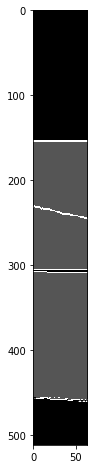

saved_array 7
[1 2 3 5 7]


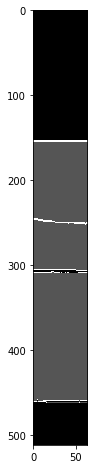

saved_array 8
[1 2 3 5 7]


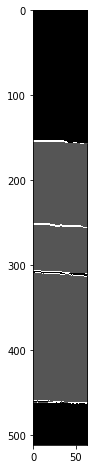

saved_array 9
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H2_N02047_LA_1_241/
Resized_train
con_H2_N02047_LA_1_241.tif
label_H2_N02047_LA_1_241.JPG
[0 1 2 3 4 5 7]
(512, 64)


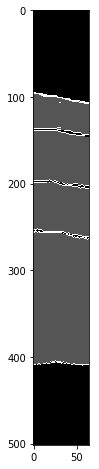

saved_array 1
[0 1 2 3 4 5 7]
(512, 64)


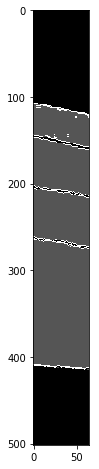

saved_array 2
[0 1 2 3 4 5 7]
(512, 64)


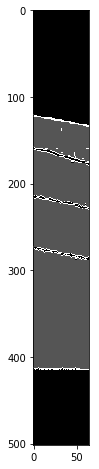

saved_array 3
[0 1 2 3 4 5 7]
(512, 64)


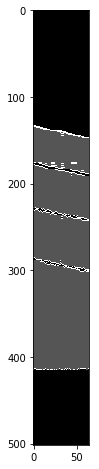

saved_array 4
[0 1 2 3 4 5 7]
(512, 64)


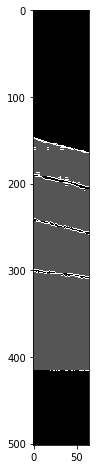

saved_array 5
[0 1 2 3 4 5 7]
(512, 64)


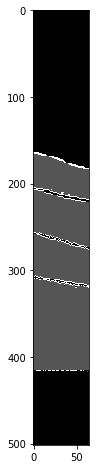

saved_array 6
[0 1 2 3 4 5 7]
(512, 64)


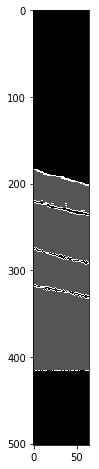

saved_array 7
[0 1 2 3 4 5 7]
(512, 64)


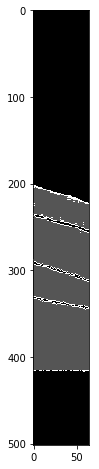

saved_array 8
[0 1 2 3 4 5 7]
(512, 64)


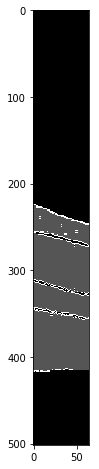

saved_array 9
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H2_N02047_LA_1_257/
Resized_train
label_H2_N02047_LA_1_257.JPG
[0 1 2 3 4 5 7]
(512, 64)


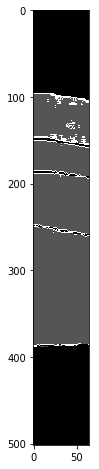

saved_array 1
[0 1 2 3 4 5 7]
(512, 64)


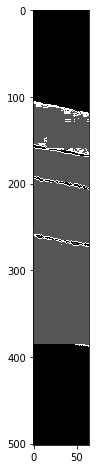

saved_array 2
[0 1 2 3 4 5 7]
(512, 64)


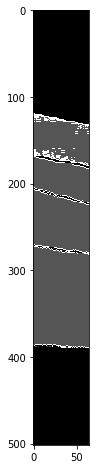

saved_array 3
[0 1 2 3 4 5 6 7]
(512, 64)


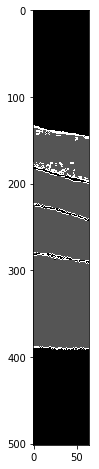

saved_array 4
[0 1 2 3 4 5 7]
(512, 64)


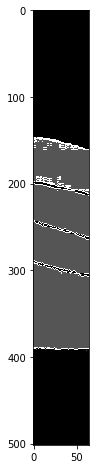

saved_array 5
[0 1 2 3 4 5 7]
(512, 64)


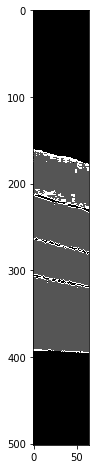

saved_array 6
[0 1 2 3 4 5 7]
(512, 64)


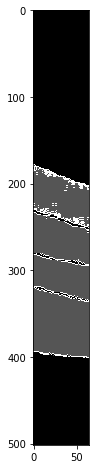

saved_array 7
[0 1 2 3 4 5 6 7]
(512, 64)


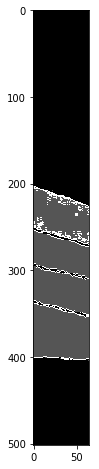

saved_array 8
[0 1 2 3 4 5 7]
(512, 64)


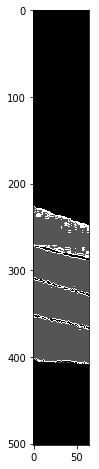

saved_array 9
con_H2_N02047_LA_1_257.tif
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H2_N02047_RA_1_380/
Resized_train
label_H2_N02047_RA_1_380.JPG
[0 2 3 4 7]
(512, 64)


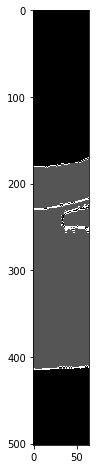

saved_array 1
[0 2 3 4 7]
(512, 64)


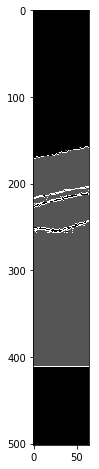

saved_array 2
[0 2 3 4 6 7]
(512, 64)


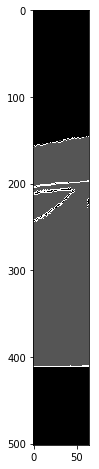

saved_array 3
[0 2 3 4 7]
(512, 64)


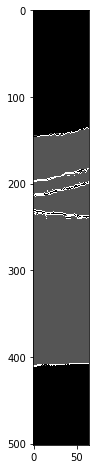

saved_array 4
[0 2 3 4 7]
(512, 64)


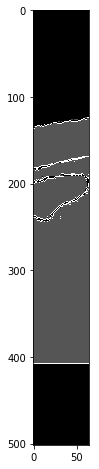

saved_array 5
[2 3 4 7]
(512, 64)


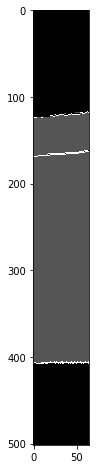

saved_array 6
[2 3 4 7]
(512, 64)


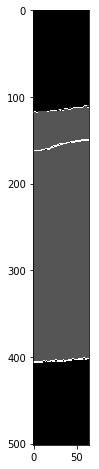

saved_array 7
[2 3 4 7]
(512, 64)


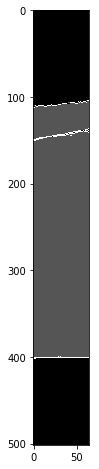

saved_array 8
[0 2 3 4 6 7]
(512, 64)


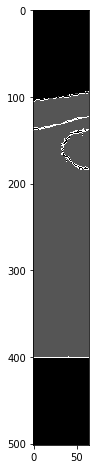

saved_array 9
con_H2_N02047_RA_1_380.tif
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H2_N02047_RA_1_400/
Resized_train
con_H2_N02047_RA_1_400.tif
label_H2_N02047_RA_1_400.JPG
[0 2 3 4 7]
(512, 64)


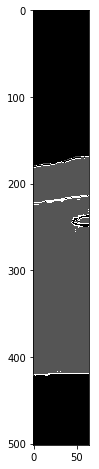

saved_array 1
[0 2 3 4 7]
(512, 64)


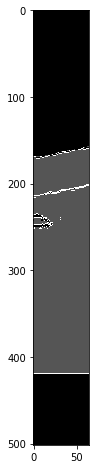

saved_array 2
[0 2 3 4 7]
(512, 64)


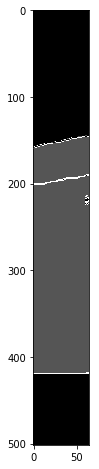

saved_array 3
[0 2 3 4 7]
(512, 64)


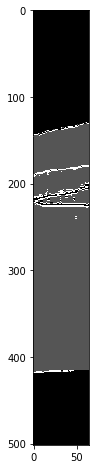

saved_array 4
[0 2 3 4 7]
(512, 64)


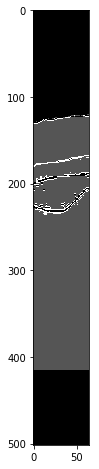

saved_array 5
[0 2 3 4 7]
(512, 64)


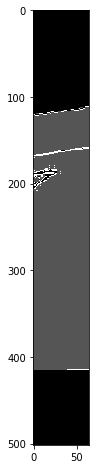

saved_array 6
[2 3 4 7]
(512, 64)


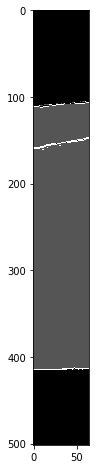

saved_array 7
[2 3 4 5 6 7]
(512, 64)


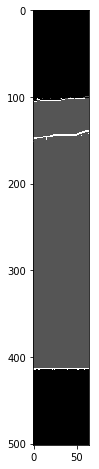

saved_array 8
[0 2 3 4 5 6 7]
(512, 64)


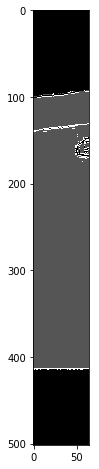

saved_array 9
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H3_N02186_LA_1_400/
Resized_train
con_H3_N02186_LA_1_400.tif
label_H3_N02186_LA_1_400.JPG
[0 4 7]
(512, 64)


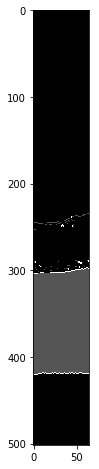

saved_array 1
[0 4 6 7]
(512, 64)


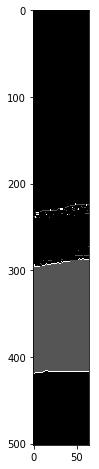

saved_array 2
[0 4 6 7]
(512, 64)


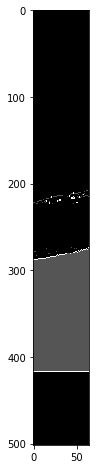

saved_array 3
[0 4 7]
(512, 64)


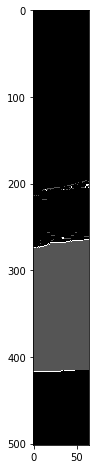

saved_array 4
[0 4 5 7]
(512, 64)


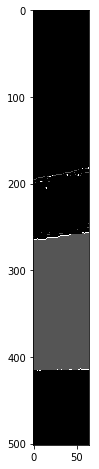

saved_array 5
[0 4 7]
(512, 64)


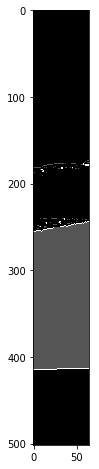

saved_array 6
[0 4 6 7]
(512, 64)


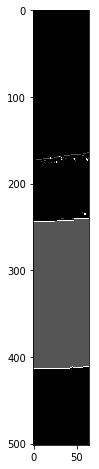

saved_array 7
[0 4 6 7]
(512, 64)


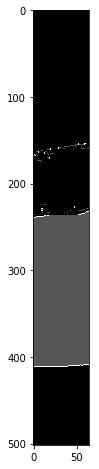

saved_array 8
[0 4 5 6 7]
(512, 64)


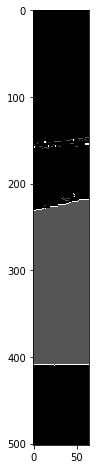

saved_array 9
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H3_N02186_LA_1_416/
Resized_train
con_H3_N02186_LA_1_416.tif
label_H3_N02186_LA_1_416.JPG
[0 4 7]
(512, 64)


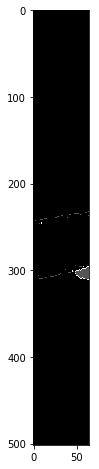

saved_array 1
[0 4 7]
(512, 64)


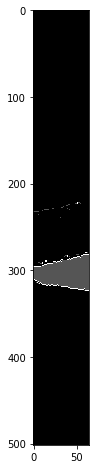

saved_array 2
[0 4 7]
(512, 64)


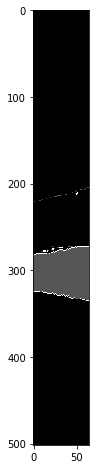

saved_array 3
[0 4 5 6 7]
(512, 64)


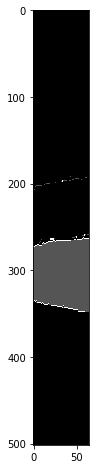

saved_array 4
[0 4 7]
(512, 64)


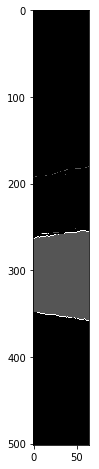

saved_array 5
[0 4 7]
(512, 64)


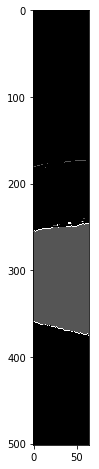

saved_array 6
[0 4 7]
(512, 64)


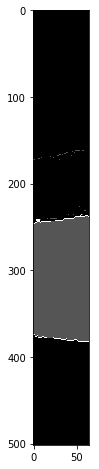

saved_array 7
[0 3 4 5 6 7]
(512, 64)


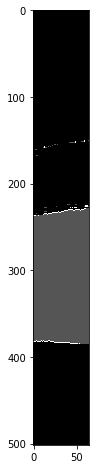

saved_array 8
[0 4 5 6 7]
(512, 64)


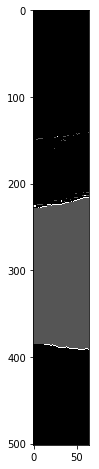

saved_array 9
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H3_N02186_RA_1_380/
Resized_train
con_H3_N02186_RA_1_380.tif
label_H3_N02186_RA_1_380.JPG
[1 2 3 4 5 7]
(512, 64)


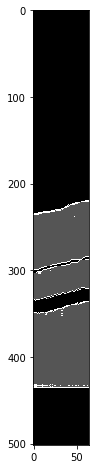

saved_array 1
[1 2 3 5 7]
(512, 64)


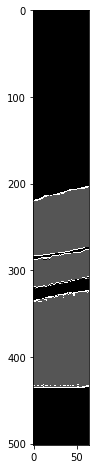

saved_array 2
[1 2 3 4 5 6 7]
(512, 64)


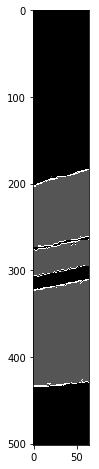

saved_array 3
[1 2 3 4 5 6 7]
(512, 64)


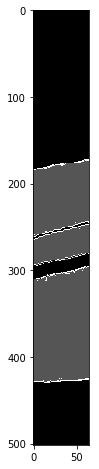

saved_array 4
[1 2 3 4 5 7]
(512, 64)


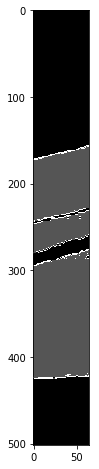

saved_array 5
[0 1 2 3 4 5 7]
(512, 64)


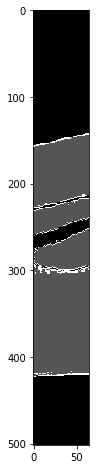

saved_array 6
[0 1 2 3 4 5 7]
(512, 64)


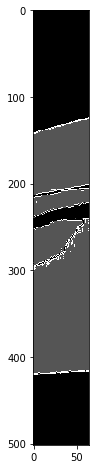

saved_array 7
[1 2 3 4 5 6 7]
(512, 64)


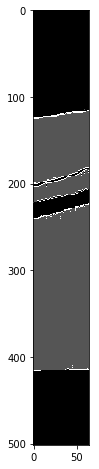

saved_array 8
[1 2 3 4 5 7]
(512, 64)


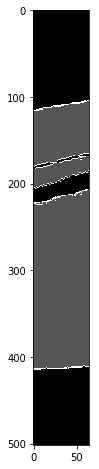

saved_array 9
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H3_N02186_RA_1_400/
Resized_train
label_H3_N02186_RA_1_400.JPG
[1 2 3 4 5 7]
(512, 64)


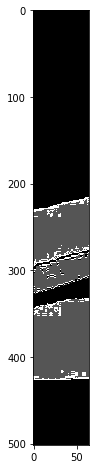

saved_array 1
[1 2 3 4 5 7]
(512, 64)


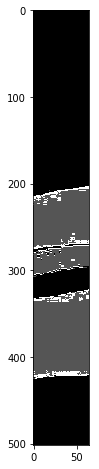

saved_array 2
[1 2 3 4 5 7]
(512, 64)


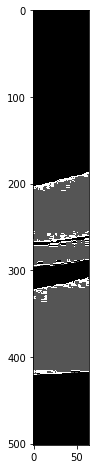

saved_array 3
[1 2 3 4 5 7]
(512, 64)


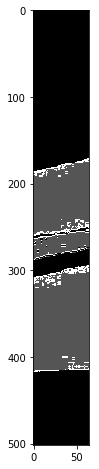

saved_array 4
[1 2 3 4 5 6 7]
(512, 64)


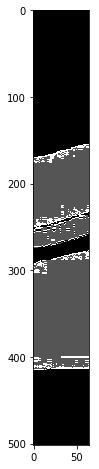

saved_array 5
[1 2 3 5 6 7]
(512, 64)


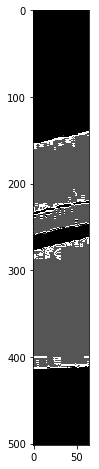

saved_array 6
[1 2 3 4 5 7]
(512, 64)


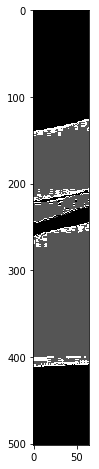

saved_array 7
[1 2 3 4 5 7]
(512, 64)


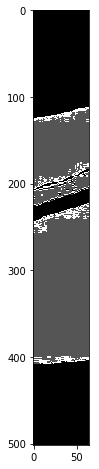

saved_array 8
[1 2 3 4 5 7]
(512, 64)


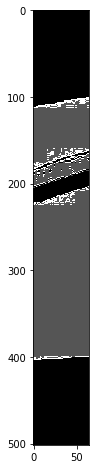

saved_array 9
con_H3_N02186_RA_1_400.tif
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H4_N03210_RA_1_400/
Resized_train
label_H4_N03210_RA_1_400.JPG
[2 3 4 5 6 7]
(512, 64)


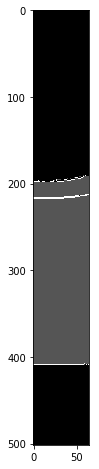

saved_array 1
[2 3 4 5 6 7]
(512, 64)


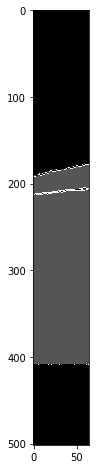

saved_array 2
[2 3 4 6 7]
(512, 64)


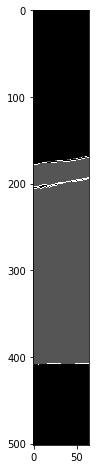

saved_array 3
[2 3 4 5 7]
(512, 64)


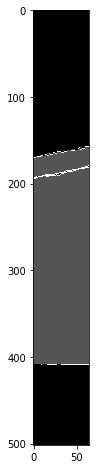

saved_array 4
[2 3 4 6 7]
(512, 64)


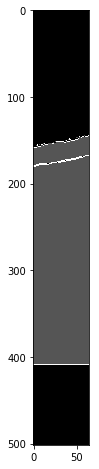

saved_array 5
[2 3 4 6 7]
(512, 64)


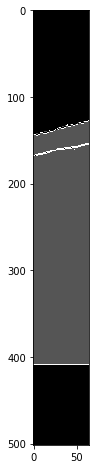

saved_array 6
[2 3 4 6 7]
(512, 64)


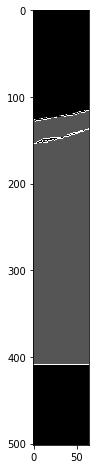

saved_array 7
[2 3 4 5 6 7]
(512, 64)


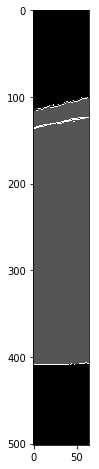

saved_array 8
[2 3 4 5 6 7]
(512, 64)


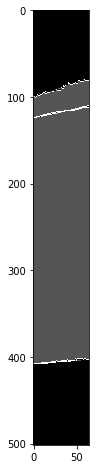

saved_array 9
con_H4_N03210_RA_1_400.tif
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H4_N03210_RA_1_440/
Resized_train
label_H4_N03210_RA_1_440.JPG
[2 4 5 6 7]
(512, 64)


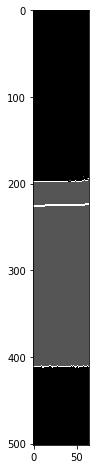

saved_array 1
[2 3 4 7]
(512, 64)


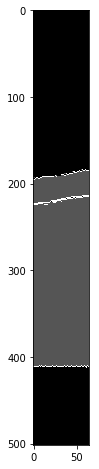

saved_array 2
[2 3 4 7]
(512, 64)


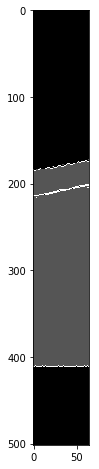

saved_array 3
[2 4 5 6 7]
(512, 64)


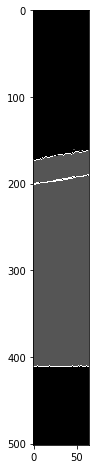

saved_array 4
[2 3 4 5 7]
(512, 64)


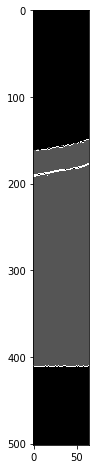

saved_array 5
[2 3 4 6 7]
(512, 64)


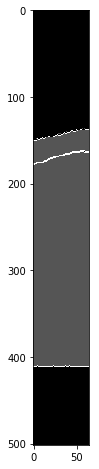

saved_array 6
[2 3 4 5 6 7]
(512, 64)


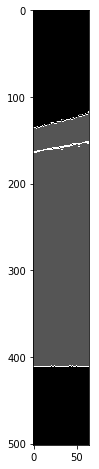

saved_array 7
[2 3 4 5 6 7]
(512, 64)


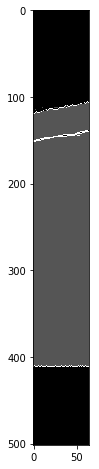

saved_array 8
[2 3 4 5 7]
(512, 64)


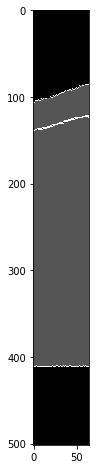

saved_array 9
con_H4_N03210_RA_1_440.tif
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H5_N03290_LA_1_380/
Resized_train
label_H5_N03290_LA_1_380.JPG
[1 2 3 4 5 7]
(512, 64)


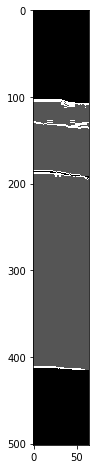

saved_array 1
[1 2 3 4 5 7]
(512, 64)


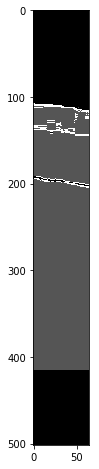

saved_array 2
[1 2 3 5 7]
(512, 64)


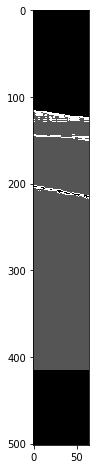

saved_array 3
[1 2 3 4 5 6 7]
(512, 64)


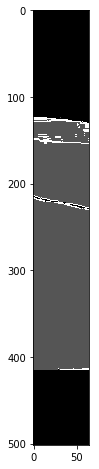

saved_array 4
[1 2 3 5 7]
(512, 64)


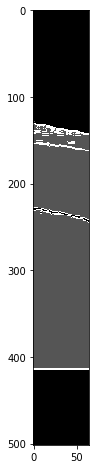

saved_array 5
[1 2 3 5 7]
(512, 64)


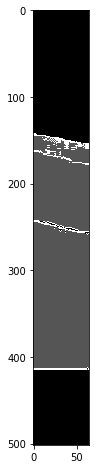

saved_array 6
[1 2 3 4 5 7]
(512, 64)


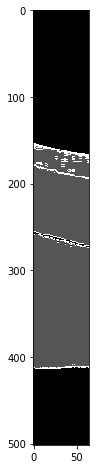

saved_array 7
[1 2 3 5 7]
(512, 64)


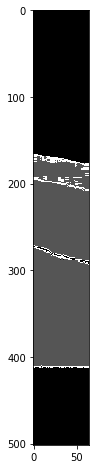

saved_array 8
[1 2 3 4 5 7]
(512, 64)


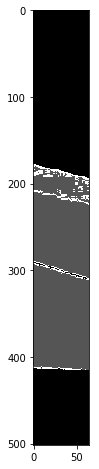

saved_array 9
con_H5_N03290_LA_1_380.tif
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H5_N03290_LA_1_400/
Resized_train
con_H5_N03290_LA_1_400.tif
label_H5_N03290_LA_1_400.JPG
[1 2 3 5 7]
(512, 64)


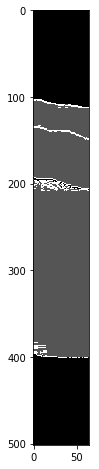

saved_array 1
[1 2 3 5 7]
(512, 64)


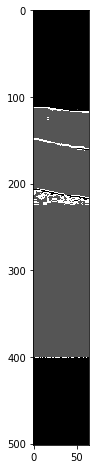

saved_array 2
[1 2 3 5 7]
(512, 64)


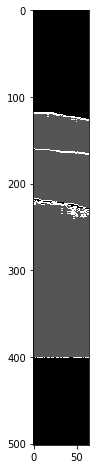

saved_array 3
[1 2 3 5 7]
(512, 64)


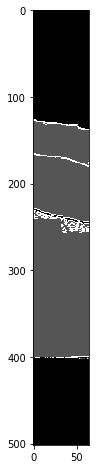

saved_array 4
[1 2 3 5 7]
(512, 64)


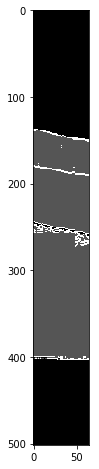

saved_array 5
[1 2 3 5 7]
(512, 64)


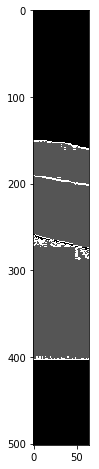

saved_array 6
[1 2 3 5 7]
(512, 64)


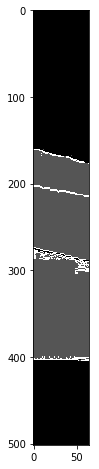

saved_array 7
[1 2 3 5 7]
(512, 64)


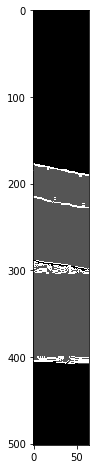

saved_array 8
[1 2 3 5 6 7]
(512, 64)


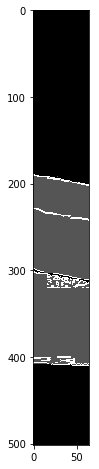

saved_array 9
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H6_N03320_LA_1_391/
Resized_train
label_H6_N03320_LA_1_391.JPG
[1 2 3 4 5 7]
(512, 64)


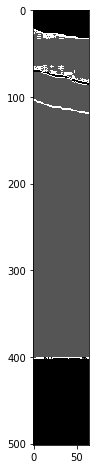

saved_array 1
[1 2 3 4 5 6 7]
(512, 64)


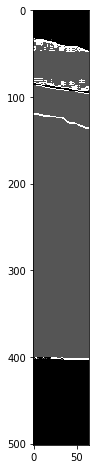

saved_array 2
[1 2 3 4 5 7]
(512, 64)


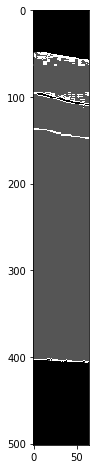

saved_array 3
[0 1 2 3 4 5 7]
(512, 64)


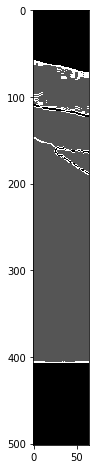

saved_array 4
[0 1 2 3 4 5 7]
(512, 64)


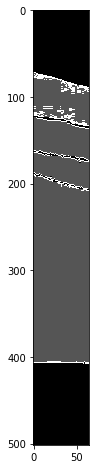

saved_array 5
[0 1 2 3 4 5 7]
(512, 64)


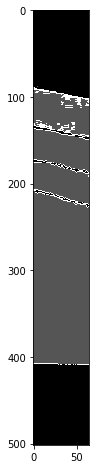

saved_array 6
[0 1 2 3 4 5 7]
(512, 64)


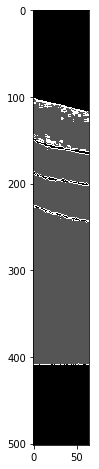

saved_array 7
[0 1 2 3 4 5 7]
(512, 64)


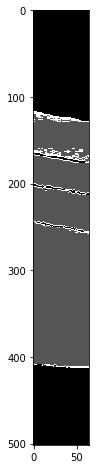

saved_array 8
[0 1 2 3 4 5 7]
(512, 64)


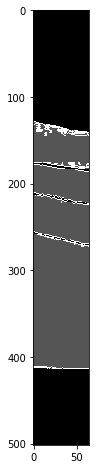

saved_array 9
con_H6_N03320_LA_1_391.tif
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H6_N03320_LA_1_450/
Resized_train
con_H6_N03320_LA_1_450.tif
label_H6_N03320_LA_1_450.JPG
[1 2 3 4 5 7]
(512, 64)


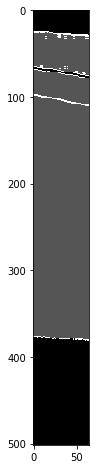

saved_array 1
[1 2 3 4 5 7]
(512, 64)


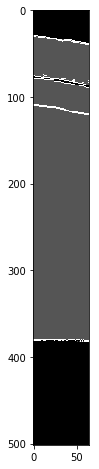

saved_array 2
[1 2 3 4 5 7]
(512, 64)


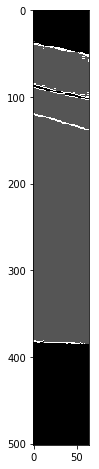

saved_array 3
[1 2 3 4 5 7]
(512, 64)


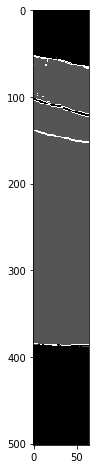

saved_array 4
[1 2 3 4 5 7]
(512, 64)


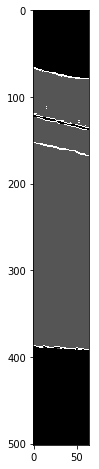

saved_array 5
[0 1 2 3 4 5 6 7]
(512, 64)


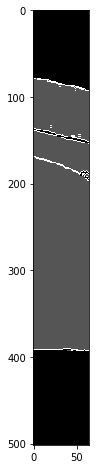

saved_array 6
[0 1 2 3 4 5 7]
(512, 64)


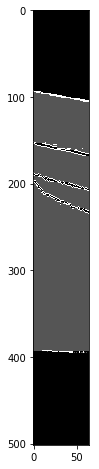

saved_array 7
[0 1 2 3 4 5 6 7]
(512, 64)


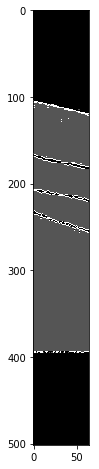

saved_array 8
[0 1 2 3 4 5 7]
(512, 64)


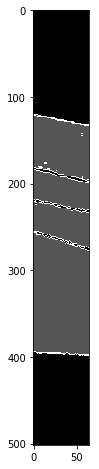

saved_array 9
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H6_N03320_RA_1_420/
Resized_train
label_H6_N03320_RA_1_420.JPG
[1 3 4 5 7]
(512, 64)


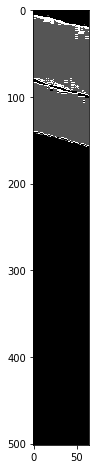

saved_array 1
[1 3 4 5 7]
(512, 64)


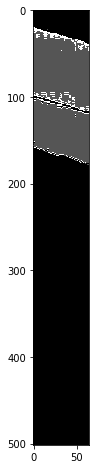

saved_array 2
[1 3 4 5 6 7]
(512, 64)


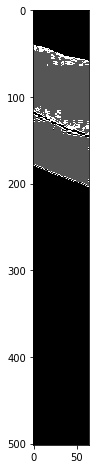

saved_array 3
[0 1 3 5 7]
(512, 64)


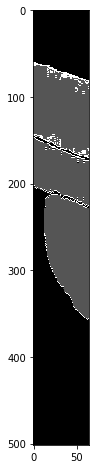

saved_array 4
[0 1 3 5 7]
(512, 64)


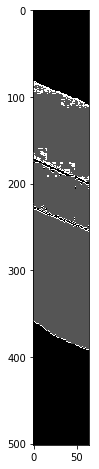

saved_array 5
[0 1 3 5 7]
(512, 64)


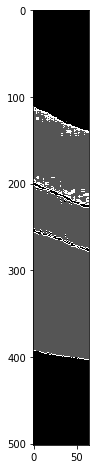

saved_array 6
[0 1 3 5 7]
(512, 64)


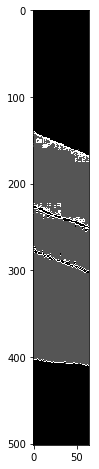

saved_array 7
[0 1 3 5 7]
(512, 64)


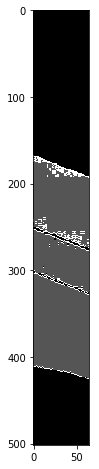

saved_array 8
[0 1 3 5 6 7]
(512, 64)


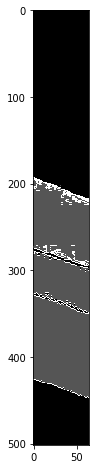

saved_array 9
con_H6_N03320_RA_1_420.tif
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H7_N03555_RA_1_302/
Resized_train
label_H7_N03555_RA_1_302.JPG
[2 3 4 5 6 7]


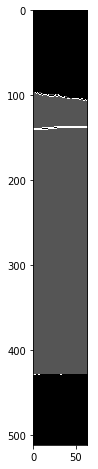

saved_array 1
[2 3 4 5 6 7]


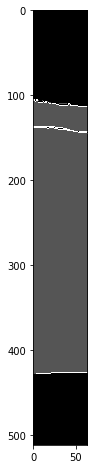

saved_array 2
[2 4 7]


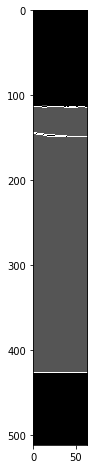

saved_array 3
[2 3 4 5 6 7]


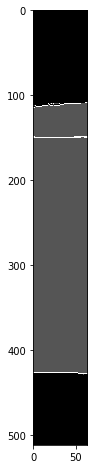

saved_array 4
[2 3 4 7]


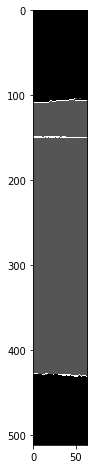

saved_array 5
[2 3 4 5 6 7]


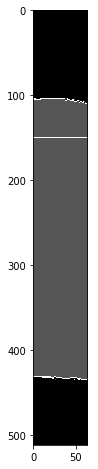

saved_array 6
[2 3 4 5 6 7]


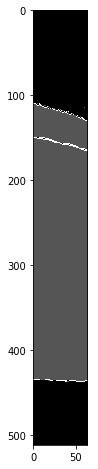

saved_array 7
[2 3 4 5 6 7]


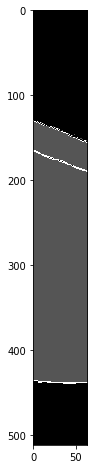

saved_array 8
[2 3 4 5 6 7]


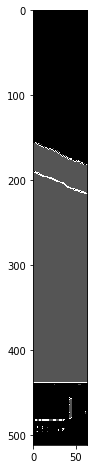

saved_array 9
con_H7_N03555_RA_1_302.tif
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H8_N03585_RA_1_345/
Resized_train
label_H8_N03585_RA_1_345.JPG
[0 2 4 7]
(512, 64)


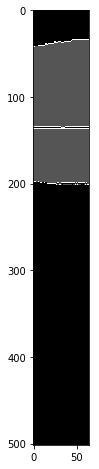

saved_array 1
[0 2 4 7]
(512, 64)


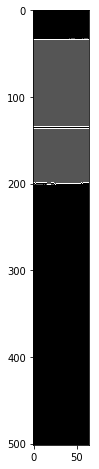

saved_array 2
[0 2 4 7]
(512, 64)


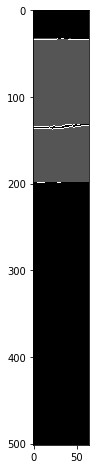

saved_array 3
[0 4 5 7]
(512, 64)


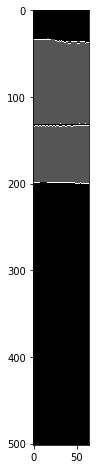

saved_array 4
[0 4 7]
(512, 64)


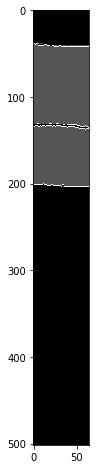

saved_array 5
[0 4 5 7]
(512, 64)


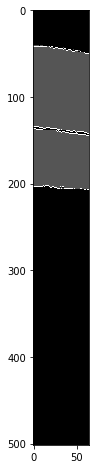

saved_array 6
[0 4 5 6 7]
(512, 64)


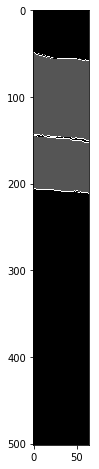

saved_array 7
[0 4 5 7]
(512, 64)


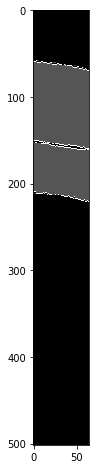

saved_array 8
[0 4 7]
(512, 64)


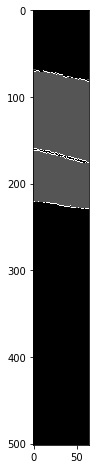

saved_array 9
con_H8_N03585_RA_1_345.tif


In [15]:
make_segments = True

# copy('/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H1_N01848_LA_1_272/Resized_train/con_H1_N01848_LA_1_272_1.tif', atrium_folder)
if make_segments:
    for number, filename in sorted(files.items()):
        if files[number][-2:] == 'h5':
            continue
        
        sub_directory = directory+files[number]+'/'
        print(sub_directory)
        for f in os.listdir(sub_directory):
            ext = f[-4:]
            shape = 2
            print(f)
            if ext == raw_ext or ext == label_ext:
                image_file = sub_directory+f
                image = plt.imread(image_file)
                
                # Crop all images
                if len(image.shape) == 2:
                    height, width = image.shape
                    if width > 600:
                        image = crop_image(image, 0, 600) # Crop all images at 512,600
                elif len(image.shape) == 3:
                    height, width, colour = image.shape
                    if width > 600:
                        image = crop_image(image, 0, 600, colour) # Crop all images at 512,600
                
                # Segment all iamges
                segmented_images = segment_image(image, 0, 600, 64)
                for i in range(len(segmented_images)):
                    if len(image.shape) == 2:
                        save_image(segmented_images[i], sub_directory, f, ext, i, False) # save_image because already raw image
                    elif len(image.shape) == 3:
                        save_all(segmented_images[i], sub_directory, f, ext, i)

In [16]:
# sub_directory = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H1_N01848_LA_1_272/'
# word = 'label_H1_N01848_LA_1_272.JPG'
# ext = '.JPG'
# i = 0
# image_file = sub_directory + word
# image = plt.imread(image_file)
# segmented_images = segment_image(image, 0, 600, 64)
# show_main_image(segmented_images[0])
# save_all(segmented_images[0], sub_directory, word, ext, i)

# Copy Files into new folder
atrium_folder = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/atrium_data/'
raw_image_folder = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/whole_raw_image/'
manual_label_folder = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/manual_label/'
copy_files = False
if copy_files:
    from shutil import copy
    for number, filename in sorted(files.items()):
        if filename[-2:] != 'h5':
            sub_directory = directory+files[number]+'/'
           
            for f in os.listdir(sub_directory):
                ext = f[-4:]
                src = sub_directory+f
                if ext == '.JPG':
                    copy(src,manual_label_folder)
                elif ext =='.tif':
                    copy(src,raw_image_folder)
#             if f == 'Resized_train':
#                 resize_direct = sub_directory+f
#                 for p in os.listdir(resize_direct):
#                     
#                     src = resize_direct+'/'+p
#                     if ext == '.npy' or ext == '.tif':
#                         copy(src,atrium_folder)

Testing moving files was done correctly - it was 

In [17]:
# produce_images('/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H8_N03585_RA_1_345/label_H8_N03585_RA_1_345.JPG')
# test_id = np.load(atrium_folder+'label_H8_N03585_RA_1_345_id_1.npy')

# show_main_image(test_id)
# rgb_image = convert_to_rgb_image(test_id)
# show_main_image(rgb_image)

#### Create IMDB of dataset - HP5

In [18]:
import numpy as np
import h5py
import fnmatch

In [19]:
count = 0
files_array = []
folder_names = []
for number, filename in sorted(files.items()):
    if files[number][-2:] != 'h5':
        sub_directory = directory+files[number]+'/Resized_train/'
        folder_names.append(files[number]) # appending names of folder to list
        no_files = len(fnmatch.filter(os.listdir(sub_directory), '*.tif'))
        count = count + no_files
H = 512
W = 64
N = count
print(N)
print(sub_directory)

171
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Atrium/H8_N03585_RA_1_345/Resized_train/


In [20]:
atrium_ids = cwd + '/datasets/OCTData/atrium_data/ids/'
atrium_weights = cwd + '/datasets/OCTData/atrium_data/weights/'
atrium_raw = cwd + '/datasets/OCTData/atrium_data/raw/'

atrium_id_files = {}
atrium_weights_files = {}
atrium_raw_files = {}
for number, filename in enumerate(sorted(os.listdir(atrium_ids)), start=1):
    atrium_id_files[number] = filename
for number, filename in enumerate(sorted(os.listdir(atrium_weights)), start=1):
    atrium_weights_files[number] = filename
for number, filename in enumerate(sorted(os.listdir(atrium_raw)), start=1):
    atrium_raw_files[number] = filename

In [21]:
def make_h5py_array(name, dictionary, count):
    id_files = []
    atr_direct = '/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/atrium_data/'

    for number, filename in sorted(dictionary.items()):

        sub_directory = atr_direct+name+'/'+dictionary[number]
        if count == 163:
            print(sub_directory)
        if name == 'raw':
            act_file = plt.imread(sub_directory)
            act_file = np.array(act_file)
        else:
            act_file = np.load(sub_directory)
        id_files.append(act_file)
        count += 1
    return id_files
count = 0
id_files = make_h5py_array('ids', atrium_id_files, count)
count = 0
weight_files = make_h5py_array('weights', atrium_weights_files, count)
count = 0
raw_files = make_h5py_array('raw', atrium_raw_files, count)

/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/atrium_data/ids/label_H8_N03585_RA_1_345_id_2.npy
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/atrium_data/weights/label_H8_N03585_RA_1_345_weight_2.npy
/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/atrium_data/raw/con_H8_N03585_RA_1_345_2.tif


In [22]:
import torch

# Creating Data.h5 File
data = np.zeros((N,1, H, W))

for i in range(N):
    image = raw_files[i] # array of size (H,W)
    for m in range(H):
        for n in range(W):
            data[i, 0, m, n] = image[m,n]
    
data = torch.from_numpy(data).float()
print(data.shape)
hf = h5py.File('/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/Data.h5', 'w')
hf.create_dataset('data', data=data) # creating raw data dataset - group name followed by dimensions in [H,W,Channel,DataIndex]
hf.close()

torch.Size([171, 1, 512, 64])


In [23]:
# Creating label.h5 File
labels = np.zeros((N,2, H, W))

for i in range(N):
    weights = weight_files[i] # array of size (H,W)
    ids = id_files[i] # array of size (H,W) # class is your colour
    
    h,w = ids.shape
    if h != 512 or w != 64:
#         print(h,w)
        amount = H - h
        weight_full = np.full((amount, 64), 1.0)
        id_full = np.full((amount, 64), 7)
        weights = np.concatenate((weights, weight_full))
        ids = np.concatenate((ids, id_full))   
    new_id = np.copy(ids)
    for m in range(H):
        for n in range(W):
            if ids[m,n] > 7:
                # set all label values to 7 
                new_id[m,n] = 7
            labels[i, 0, m, n] = new_id[m,n]
            labels[i, 1, m, n] = weights[m,n]

labels = torch.from_numpy(labels).float()
print(np.unique(labels[:,0,:,:]))
print('Finalshape:',labels.shape)

hf = h5py.File('/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/label.h5', 'w')
hf.create_dataset('labels', data=labels) 
hf.close()

[ 0.  1.  2.  3.  4.  5.  6.  7.]
Finalshape: torch.Size([171, 2, 512, 64])


In [24]:
# Creating set.h5 File
sets = np.ones((1,N))
split = N * 0.8
sets[:,int(split):] = 3

hf = h5py.File('/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/set.h5', 'w')
hf.create_dataset('set', data=sets)
hf.close()